# Titanic survival

A famous dataset, it seems to me that everybody, who is interested in data science, worked with it.

A model, built here, is not the best model on test set, but selected using cross validation, as in real life we don't use test set to choose the best model. The highest score achieved is 0.81340 and it belongs to Top 400. If you want to reproduce it, several advises:
* Use SVM model, though Gradient Boosting gives a better result on cross validation, on test set SVM performs better
* Use quadratic numerical features 
* The key moment is a good categorical feature selection

In [121]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Imputer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline

In [125]:
#importing datasets
df = pd.read_csv('train.csv', index_col = 'PassengerId')
df_test = pd.read_csv('test.csv', index_col = 'PassengerId')
y_train = df['Survived'].values
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering

As Titanic dataset is rather small with a few features included, it doesn't take much time to test new features, new models and hyperparameters tuning. Without preprocessing, features 'Name', 'Ticket', 'Cabin' don't gave a lot of sense, so following transformation and creation of new features were used:

* 'Pclass' is used as categorical features
* We use only deck letter of 'Cabin'
* We use number of persons using the same ticket as 'Ticket'
* From feature 'Name', we use only title
* Two new features 'IsChild' and 'IsExpensive' were created, as children and persons with expensive tickets had higher probability to survive

But obviously other features and categories could be created

In [126]:
#creating new features
df['Pclass'] = df['Pclass'].astype('object')
df_test['Pclass'] = df_test['Pclass'].astype('object')

df['Cabin'] = df['Cabin'].str[0]
df_test['Cabin'] = df_test['Cabin'].str[0]
df['Cabin'].fillna('Unknown', inplace = True)
df_test['Cabin'].fillna('Unknown', inplace = True)

df['IsChild'] = np.array(['Child' if x <= 16 else 'Adult' for x in df['Age']])
df_test['IsChild'] = np.array(['Child' if x <= 16 else 'Adult' for x in df_test['Age']])

df['IsExpensive'] = np.array(['Expensive' if x >= 50 else 'Cheap' for x in df['Fare']])
df_test['IsExpensive'] = np.array(['Expensive' if x >= 50 else 'Cheap' for x in df_test['Fare']])

df['Ticket'] = df['Ticket'].map(df.groupby('Ticket').size())
df_test['Ticket'] = df_test['Ticket'].map(df_test.groupby('Ticket').size())

df['Name'] = df['Name'].str.split(', ', expand = True)[1].str.split('. ', expand = True)[0]
df['Title'] = np.array([x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Other' for x in df['Name'].values])
df_test['Name'] = df_test['Name'].str.split(', ', expand = True)[1].str.split('. ', expand = True)[0]
df_test['Title'] = np.array([x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Other' for x in df_test['Name'].values])

df.drop(['Name'], axis = 1, inplace = True)
df_test.drop(['Name'], axis = 1, inplace = True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsChild,IsExpensive,Title
PassengerId,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,1,7.2500,Unknown,S,Adult,Cheap,Mr
2,1,1,female,38.0,1,0,1,71.2833,C,C,Adult,Expensive,Mrs
3,1,3,female,26.0,0,0,1,7.9250,Unknown,S,Adult,Cheap,Miss
4,1,1,female,35.0,1,0,2,53.1000,C,S,Adult,Expensive,Mrs
5,0,3,male,35.0,0,0,1,8.0500,Unknown,S,Adult,Cheap,Mr


In [127]:
#numerical features
df_num = df.select_dtypes(exclude = ['object'])
df_cat = df.select_dtypes(include = ['object'])

df_test_num = df_test.select_dtypes(exclude = ['object'])
df_test_cat = df_test.select_dtypes(include = ['object'])
df_num.describe()

//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


,Survived,Age,SibSp,Parch,Ticket,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,1.787879,32.204208
std,0.486592,14.526497,1.102743,0.806057,1.361142,49.693429
min,0.000000,0.420000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,NaN,0.000000,0.000000,1.000000,7.910400
50%,0.000000,NaN,0.000000,0.000000,1.000000,14.454200
75%,1.000000,NaN,1.000000,0.000000,2.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,7.000000,512.329200


In [128]:
#categorical features
df_cat.describe()

,Pclass,Sex,Cabin,Embarked,IsChild,IsExpensive,Title
count,891,891,891,889,891,891,891
unique,3,2,9,3,2,2,5
top,3,male,Unknown,S,Adult,Cheap,Mr
freq,491,577,687,644,791,730,517


## Numerical features

We have 5 numerical features, 'SibSp', 'Parch' and 'Ticket' have rather high positive correlation. But with 'Survived' only 'Fare' has correlation more than 0.5. Using pairplot we see, that persons with more expensive tickets and children were more liekly to survive, therefore we have created two new variables.

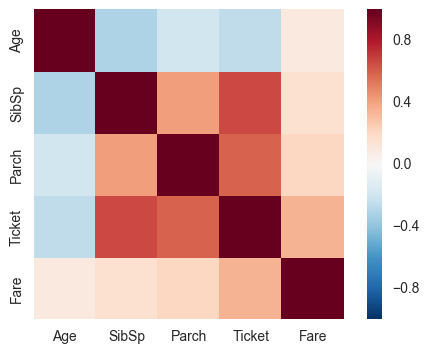

In [129]:
seaborn.heatmap(df_num.drop('Survived', axis = 1).corr(), square = True)

In [130]:
def scaling(x):
    x_scaled = (x - x.mean(skipna = True)) / x.std(skipna = True)
    return(x_scaled)

df_num_scaled = df_num.copy()
for feature in df_num.drop('Survived', axis = 1).columns:
    df_num_scaled[feature] = scaling(df_num[feature])

df_num_s = df_num_scaled[df_num_scaled['Survived'] == 1]
df_num_d = df_num_scaled[df_num_scaled['Survived'] == 0]

correlations = pd.DataFrame(df_num_s.mean(axis = 0, skipna = True) - df_num_d.mean(axis = 0, skipna = True),
                           columns = ['Correlation'])
correlations

,Correlation
Survived,1.000000
Age,-0.157126
SibSp,-0.072592
Parch,0.167757
Ticket,0.078602
Fare,0.528793


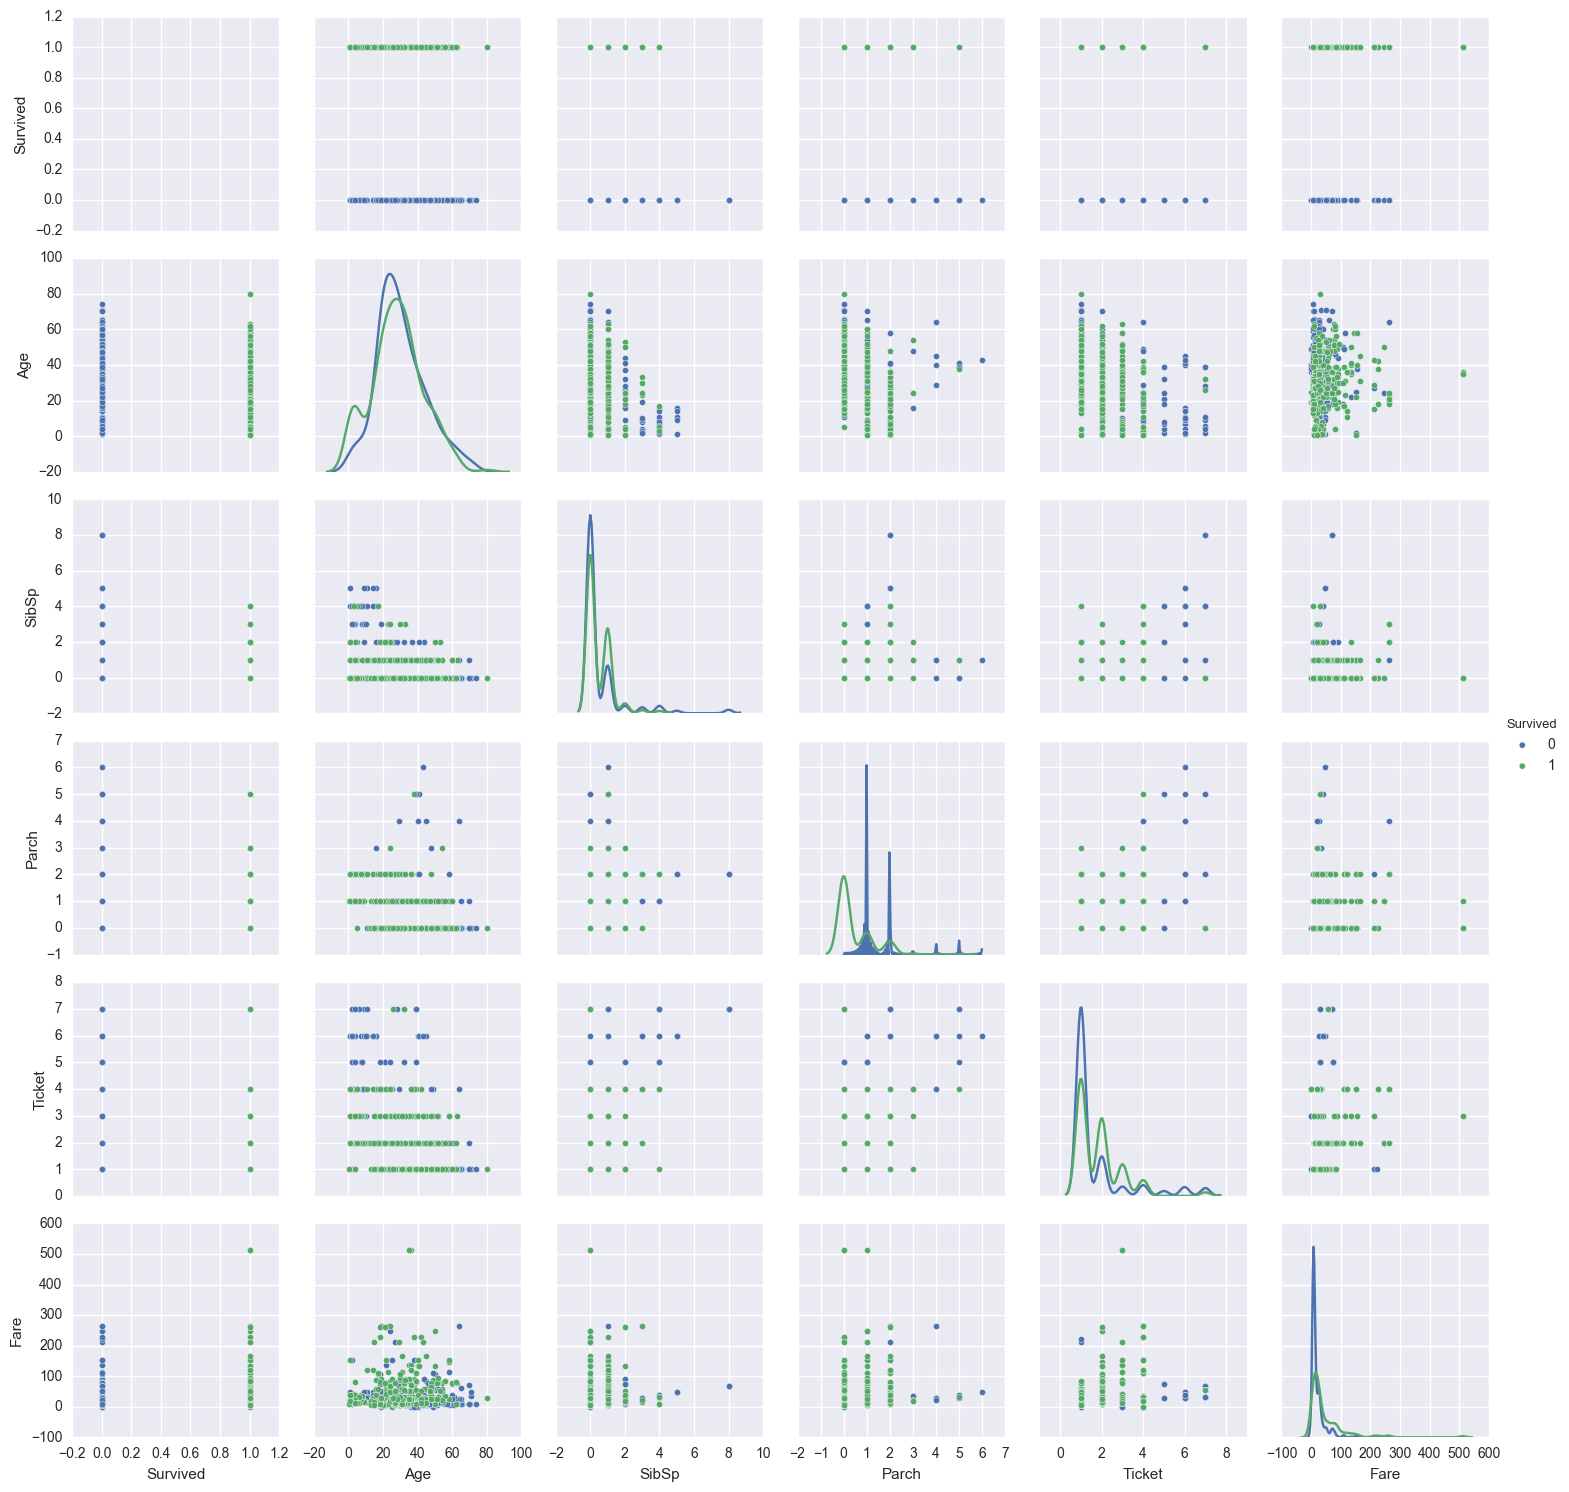

In [131]:
seaborn.pairplot(df_num, hue = 'Survived', diag_kind = 'kde')

## Categorical features

Here we can observe an influence of categorical features on survival probability. They are quite obvious: women have more chances to survive than men, first class vs. third class, children vs. adult, etc. but we see also, that knowing the deck and port of embarkment influence also.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


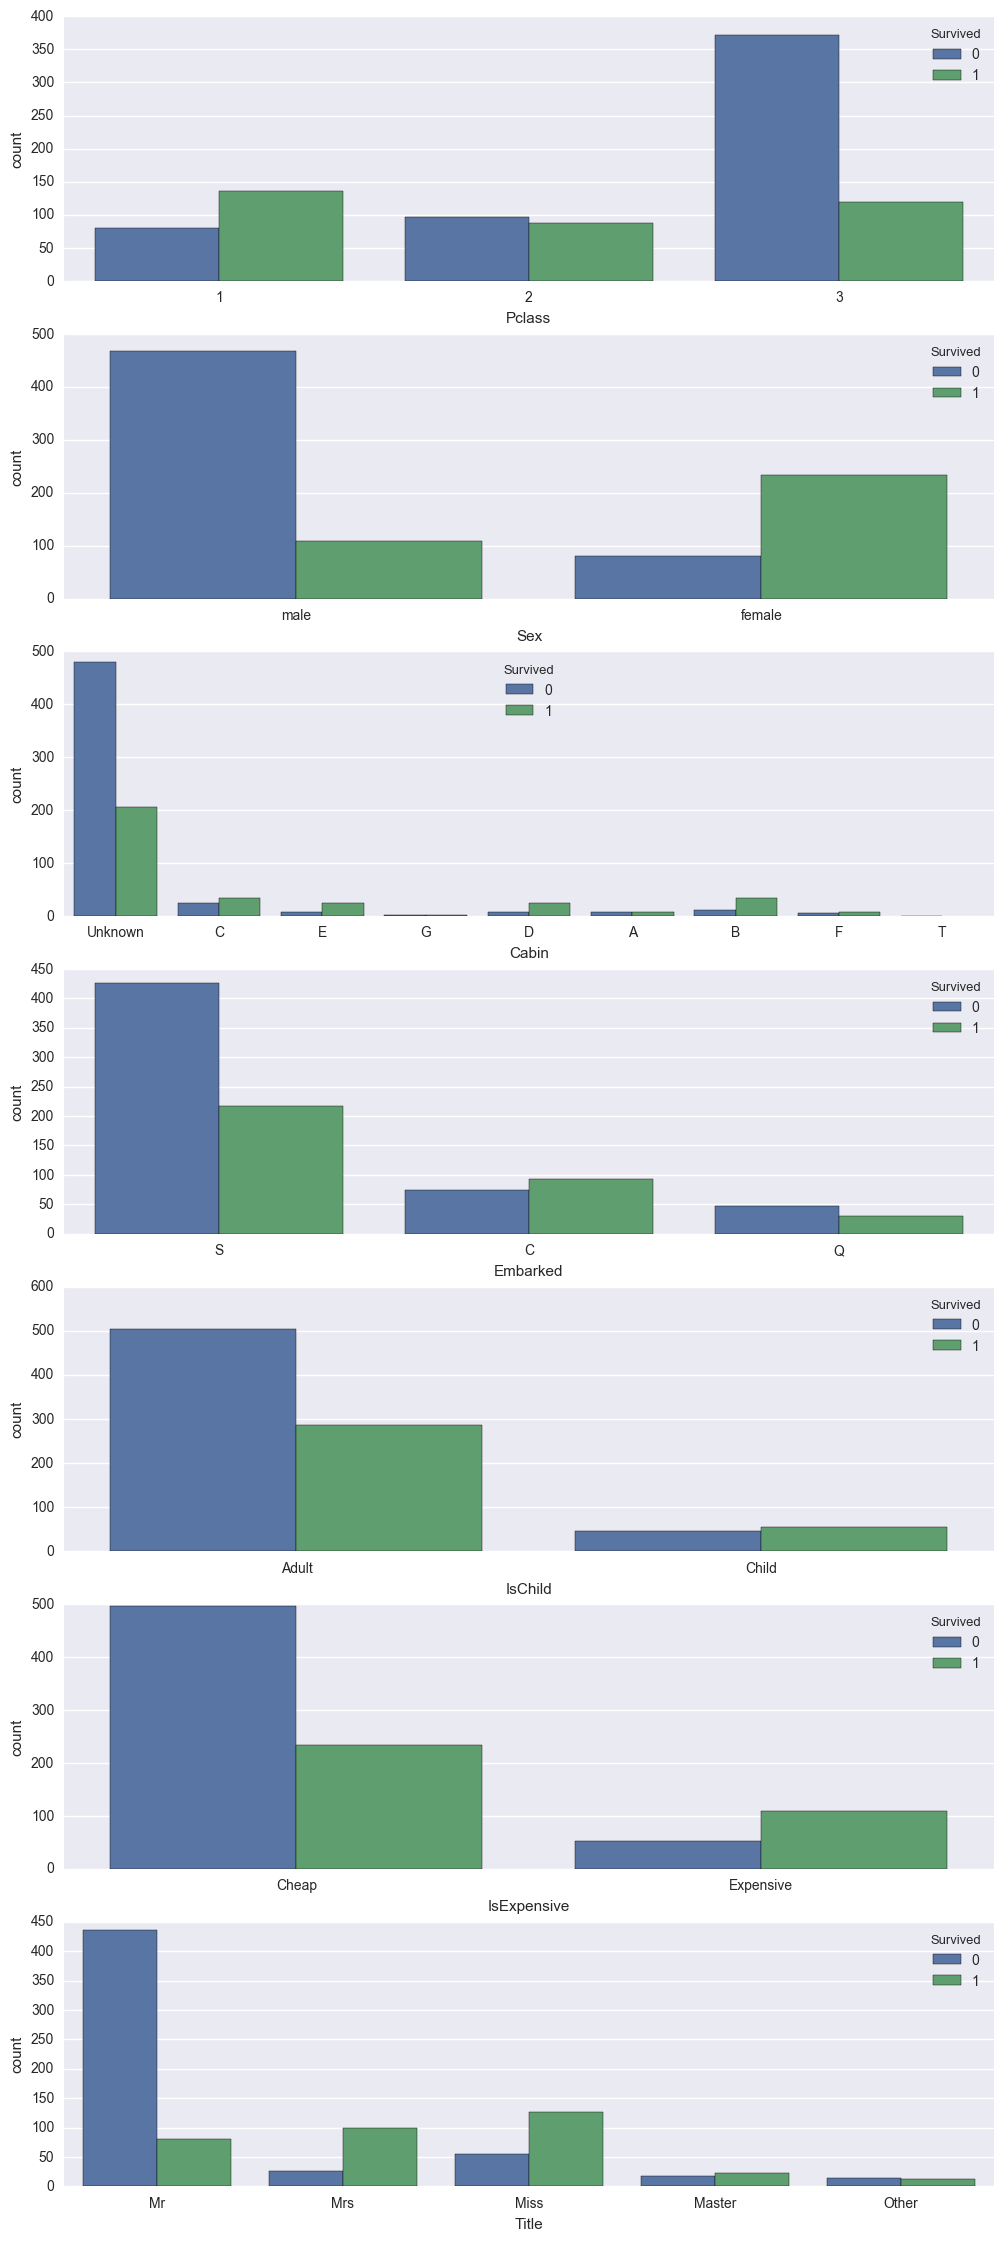

In [132]:
plt.figure(figsize = (12, 28))
df_cat['Survived'] = y_train
for i, feature in enumerate(df_cat.drop('Survived', axis = 1).columns):
    plt.subplot(7, 1, (i+1))
    seaborn.countplot(x = feature, data = df_cat, hue = 'Survived')

In [133]:
df_cat['Embarked'].fillna('S', inplace = True)
df_num.drop('Survived', axis = 1, inplace = True)
df_cat.drop('Survived', axis = 1, inplace = True)
df_test['Fare'].fillna(0, inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [150]:
# creating matrix of features
imputer = Imputer()
pf = PolynomialFeatures() 
scaler = StandardScaler()   
le = LabelEncoder()
ohe = OneHotEncoder()
X_num = imputer.fit_transform(df_num.values)
X_num = pf.fit_transform(X_num)
X_num = scaler.fit_transform(X_num)
X_test_num = imputer.transform(df_test_num.values)
X_test_num = pf.fit_transform(X_test_num)
X_test_num = scaler.transform(X_test_num)

for feature in df_cat.columns:
    df_cat[feature] = le.fit_transform(df_cat[feature].values)
    df_test_cat[feature] = le.transform(df_test_cat[feature].values)

X_cat = ohe.fit_transform(df_cat.values)
X_test_cat = ohe.transform(df_test_cat.values)
X_train = np.concatenate((X_num, X_cat.toarray()), axis = 1)
X_test = np.concatenate((X_test_num, X_test_cat.toarray()), axis = 1)
print(X_train.shape, X_test.shape)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(891, 47) (418, 47)


In [151]:
#basic models
kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 147)
svm_score = np.mean(cross_val_score(SVC(), X_train, y_train, cv = kf, scoring = 'accuracy'))
rf_score = np.mean(cross_val_score(RandomForestClassifier(n_estimators = 50, random_state = 147), 
                                   X_train, y_train, cv = kf, scoring = 'accuracy'))
gb_score = np.mean(cross_val_score(GradientBoostingClassifier(random_state = 147), 
                                   X_train, y_train, cv = kf, scoring = 'accuracy'))
print(svm_score, rf_score, gb_score)

0.826069603396 0.808111958651 0.833977600478


In [152]:
#SVM tuning
svm_class = SVC()
grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'kernel': ['rbf', 'sigmoid']}
gs_svm = GridSearchCV(svm_class, grid, cv = kf, scoring = 'accuracy')
gs_svm.fit(X_train, y_train)
print(gs_svm.best_score_, gs_svm.best_params_)

0.832772166105 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [153]:
# Random Forest Tuning
rf_class = RandomForestClassifier(random_state = 147)
grid2 = {'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200, 225, 250], 'criterion': ['gini', 'entropy']}
gs_rf = GridSearchCV(rf_class, grid2, cv = kf, scoring = 'accuracy')
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_, gs_rf.best_params_)

0.813692480359 {'n_estimators': 25, 'criterion': 'gini'}


In [154]:
#Gradient Boosting Tuning
gb_class = GradientBoostingClassifier(random_state = 147)
grid3 = {'n_estimators': [50, 100, 150, 200, 250], 'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], 
         'max_depth': [2, 3, 4, 5]}
gs_gb = GridSearchCV(gb_class, grid3, cv = kf, scoring = 'accuracy')
gs_gb.fit(X_train, y_train)
print(gs_gb.best_score_, gs_gb.best_params_)

0.840628507295 {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 4}


In [156]:
y_pred = gs_svm.predict(X_test)
df_test['Survived'] = y_pred
df_test[['Survived']].to_csv('prediction.csv', sep = ',', header = True, index = True)

Here we get that Gradient Boosting is the best model with 84% of accuracy, unfortunately it doesn't perform so good on test set, as I have mentioned in the beginning. Generally, for this data set Gradient Boosting works better on cross validation, but SVM provides higher score. Here is the proof of obtained score:

<img src="score.png">